In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from utils_data_structures import col_prefixes

In [2]:
grouped_df = pd.read_csv('sorare_data/large_grouped_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)
# grouped_df = pd.get_dummies(grouped_df, columns=['Current_Club'])
# grouped_df = grouped_df.drop(columns=['Current_Club'])

print(grouped_df['So_5_Scores_9'].isna().sum())

0


In [3]:
forwards_df = grouped_df[grouped_df['Position'] == 'Forward']
forwards_df = forwards_df.drop(columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club'])

In [4]:
forwards_df.dtypes.value_counts()

float64    308
int64        4
Name: count, dtype: int64

In [5]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = forwards_df.drop(columns=columns_to_drop)
y = forwards_df[target_column]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
y_pred_xgb_clipped = np.clip(y_pred_xgb, 0, 100)
mse = mean_squared_error(y_test, y_pred_xgb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_xgb_clipped)
print(f'r2: {r2}')

RMSE: 17.077596600651784
r2: 0.5412493981820141


In [8]:
# Initialize the LightGBM regressor
lgbm_model = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient boosting decision tree
    n_estimators=400,      # Number of boosting rounds (trees)
    learning_rate=0.01,     # Step size shrinkage
    max_depth=10,          # Unlimited depth of trees (-1 means no limit)
    random_state=42,        # For reproducibility
)

# Train the model
lgbm_model.fit(X_train, y_train)
# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
y_pred_lgmb_clipped = np.clip(y_pred_lgbm, 0, 100)
mse = mean_squared_error(y_test, y_pred_lgmb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_lgmb_clipped)
print(f'r2: {r2}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7684
[LightGBM] [Info] Number of data points in the train set: 2965, number of used features: 191
[LightGBM] [Info] Start training from score 18.712180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE: 16.504525989605906
r2: 0.5715212804281772


In [9]:

# Initialize ElasticNet
elastic_model = ElasticNet(alpha=0.05, l1_ratio=0.9, random_state=42)

# Train the model
elastic_model.fit(X_train, y_train)

# Make predictions
y_pred_en = elastic_model.predict(X_test)

# Evaluate
y_pred_en_clipped = np.clip(y_pred_en, 0, 100)
mse = mean_squared_error(y_test, y_pred_en_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_en_clipped)
print(f'r2: {r2}')

RMSE: 16.71597030947311
r2: 0.5604722216216558


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e+05, tolerance: 1.784e+02
  model = cd_fast.enet_coordinate_descent(


In [10]:
with open('sorare_models/forwards_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
    print("XGB Model saved successfully!")
with open('sorare_models/forwards_lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)
    print("LGBM Model saved successfully!")

with open('sorare_models/forwards_elastic_model.pkl', 'wb') as file:
    pickle.dump(elastic_model, file)
    print("Elastic Model saved successfully!")

print("Models saved successfully!")

XGB Model saved successfully!
LGBM Model saved successfully!
Elastic Model saved successfully!
Models saved successfully!


In [11]:
y_test_df = pd.DataFrame(y_test)
y_test_df['XBG_Predictions'] = y_pred_xgb_clipped
y_test_df['LGBM_Predictions'] = y_pred_lgmb_clipped
y_test_df['EN_Predictions'] = y_pred_en_clipped
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions
13076,37.1,40.810368,35.738490,31.723347
4267,64.5,15.925106,23.318652,21.153036
8335,32.6,32.744320,33.866773,26.145280
3163,32.3,32.506031,35.865828,37.822217
3217,43.3,42.320873,39.368920,41.606020
...,...,...,...,...
7888,0.0,0.000000,1.377829,0.583614
2382,44.6,44.508205,40.131702,44.330234
6814,0.0,25.525135,27.869762,19.772480
6760,0.0,5.753759,1.230049,1.448470


In [12]:
y_test_df['Average_Prediction'] = (y_test_df['XBG_Predictions'] + y_test_df['LGBM_Predictions'] + y_test_df['EN_Predictions']) / 3
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions,Average_Prediction
13076,37.1,40.810368,35.738490,31.723347,36.090735
4267,64.5,15.925106,23.318652,21.153036,20.132265
8335,32.6,32.744320,33.866773,26.145280,30.918791
3163,32.3,32.506031,35.865828,37.822217,35.398025
3217,43.3,42.320873,39.368920,41.606020,41.098604
...,...,...,...,...,...
7888,0.0,0.000000,1.377829,0.583614,0.653814
2382,44.6,44.508205,40.131702,44.330234,42.990047
6814,0.0,25.525135,27.869762,19.772480,24.389126
6760,0.0,5.753759,1.230049,1.448470,2.810759


In [13]:
y_true = y_test_df['So_5_Scores_9'].to_numpy()
y_pred = y_test_df['Average_Prediction'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred)
print(f'r2: {r2}')

RMSE: 16.434303753601267
r2: 0.5751596429147541


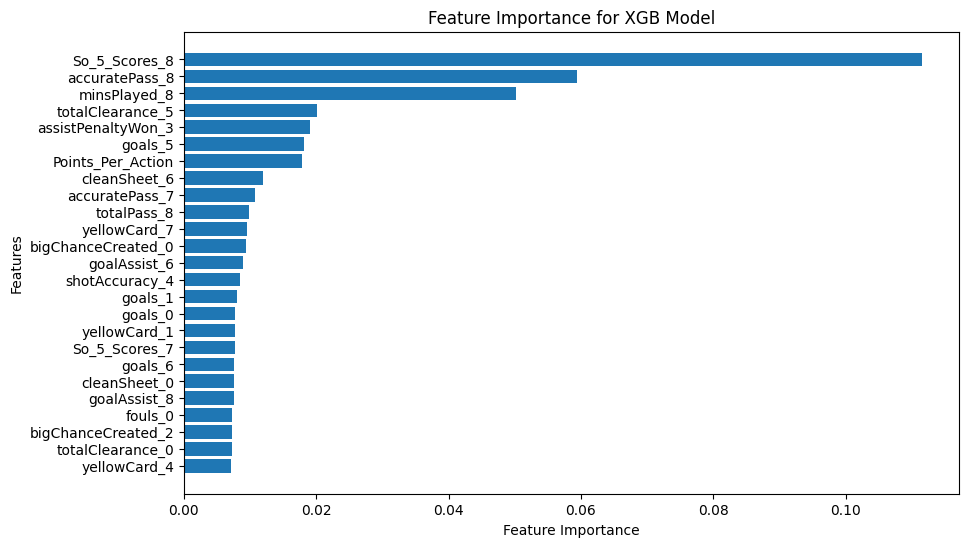

In [14]:

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for XGB Model')
plt.gca().invert_yaxis()
plt.show()

In [15]:
epl_teams = pd.read_csv('sorare_data/large_cleaned_sorare_data.csv')

epl_teams = epl_teams.fillna(0.0)

epl_forwards_df = epl_teams[epl_teams['Position'] == 'Forward']

epl_forwards_df = epl_forwards_df.reset_index(drop=True)

In [16]:
drop_columns = columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club']

columns_to_drop = [f'{col}_9' for col in col_prefixes]
columns_to_drop.extend(drop_columns)

target_column = 'So_5_Scores_9'

X_test_forwards = epl_forwards_df.drop(columns=columns_to_drop)
y_test_forwards = epl_forwards_df[target_column]

In [17]:
with open('sorare_models/forwards_xgb_model.pkl', 'rb') as file:
    forwards_xgb_model_loaded = pickle.load(file)
    print("XGB Model loaded successfully!")
with open('sorare_models/forwards_lgbm_model.pkl', 'rb') as file:
    forwards_lgbm_model_loaded = pickle.load(file)
    print("LGBM Model loaded successfully!")
with open('sorare_models/forwards_elastic_model.pkl', 'rb') as file:
    forwards_elastic_model_loaded = pickle.load(file)
    print("Elastic Model loaded successfully!")

XGB Model loaded successfully!
LGBM Model loaded successfully!
Elastic Model loaded successfully!


In [18]:
xgb_predictions = forwards_xgb_model_loaded.predict(X_test_forwards)
lgbm_predictions = forwards_lgbm_model_loaded.predict(X_test_forwards)
elastic_predictions = forwards_elastic_model_loaded.predict(X_test_forwards)

xgb_predictions = np.clip(xgb_predictions, 0, 100)
lgbm_predictions = np.clip(lgbm_predictions, 0, 100)
elastic_predictions = np.clip(elastic_predictions, 0, 100)

y_test_forwards_df = pd.DataFrame(y_test_forwards)

epl_forwards_df['sorare_xgb_predictions'] = pd.Series(xgb_predictions)
epl_forwards_df['sorare_lgbm_predictions'] = pd.Series(lgbm_predictions)
epl_forwards_df['sorare_elastic_predictions'] = pd.Series(elastic_predictions)

epl_forwards_df['sorare_predictions'] = epl_forwards_df[['sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].mean(axis=1)

epl_forwards_df[['So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].head(3)

,So_5_Scores_9,sorare_xgb_predictions,sorare_lgbm_predictions,sorare_elastic_predictions
0,47.100000,46.067547,43.798683,41.321261
1,33.423575,33.561325,35.946303,29.882432
2,0.000000,0.219769,11.980439,18.345907


In [19]:
y_true = epl_forwards_df['So_5_Scores_9'].to_numpy()
y_pred = epl_forwards_df['sorare_predictions'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_true, y_pred)
print(f'r2: {r2}')

RMSE: 14.05753928661916
r2: 0.7550120127202689


In [20]:
xgb_scores = cross_val_score(forwards_xgb_model_loaded, X, y)
lgbm_scores = cross_val_score(forwards_lgbm_model_loaded, X, y)
elastic_scores = cross_val_score(forwards_elastic_model_loaded, X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7682
[LightGBM] [Info] Number of data points in the train set: 2965, number of used features: 191
[LightGBM] [Info] Start training from score 18.608544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.761e+05, tolerance: 1.816e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.962e+03, tolerance: 1.771e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might

In [21]:
print("XGBoost scores:", xgb_scores)
print("Mean XGBoost score:", xgb_scores.mean())

print("LGBM scores:", lgbm_scores)
print("Mean LGBM score:", lgbm_scores.mean())

print("Elastic scores:", elastic_scores)
print("Mean Elastic score:", elastic_scores.mean())

XGBoost scores: [0.51133232 0.48560152 0.50828273 0.48241214 0.5328449 ]
Mean XGBoost score: 0.5040947222810932
LGBM scores: [0.54973871 0.51402024 0.5365424  0.49261302 0.56103178]
Mean LGBM score: 0.530789228454111
Elastic scores: [0.52598777 0.51037632 0.52827071 0.49453749 0.55331666]
Mean Elastic score: 0.5224977907313336


In [22]:
saved_forwards_df = epl_forwards_df[['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club','So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions', 'sorare_predictions']]
saved_forwards_df.to_csv('sorare_data/predictions/sorare_forwards_predictions.csv', index=False)

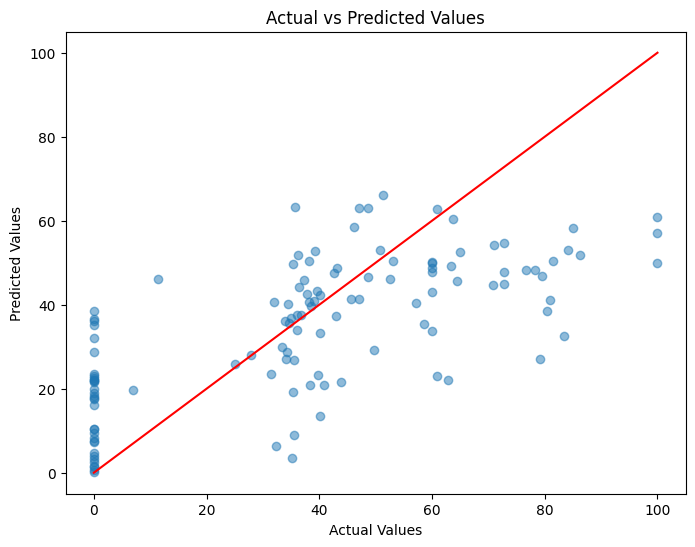

In [23]:
actual = y_true
predicted = elastic_predictions

plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.5)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red')  # Diagonal line for perfect prediction
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [24]:
models = ['forwards_xgb_model_loaded', 'forwards_lgbm_model_loaded', 'forwards_elastic_model_loaded']

xgb_r2 = r2_score(y_true, xgb_predictions)
lgbm_r2 = r2_score(y_true, lgbm_predictions)
en_r2 = r2_score(y_true, elastic_predictions)

r2_scores = [xgb_r2, lgbm_r2, en_r2]

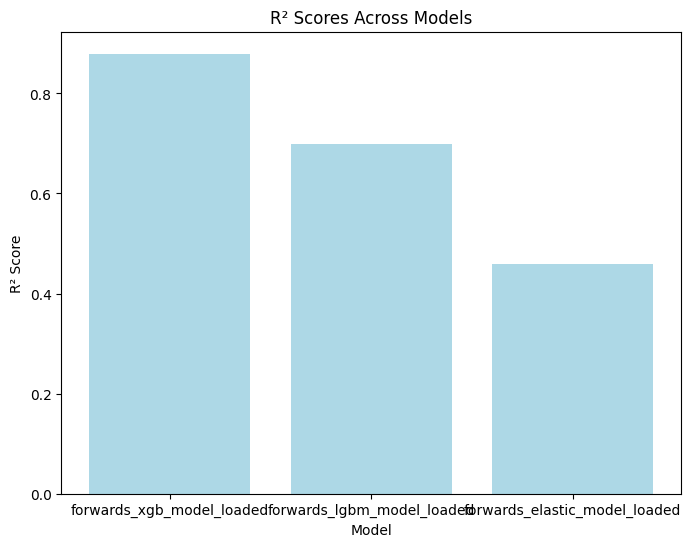

In [25]:
plt.figure(figsize=(8, 6))
plt.bar(models, r2_scores, color='lightblue')
plt.title("R² Scores Across Models")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.show()

In [26]:
mse = mean_squared_error(y_test, y_pred_xgb_clipped)
xgb_rmse = np.sqrt(mse)
mse = mean_squared_error(y_test, y_pred_lgmb_clipped)
lgbm_rmse = np.sqrt(mse)
mse = mean_squared_error(y_test, y_pred_en_clipped)
en_rmse = np.sqrt(mse)

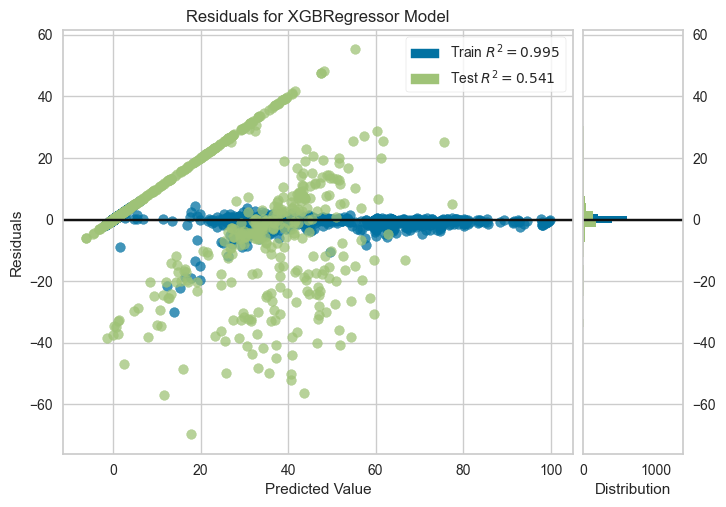

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [27]:
#residuals plot for svm
from yellowbrick.regressor import ResidualsPlot
# Initialize ResidualsPlot
visualizer = ResidualsPlot(forwards_xgb_model_loaded)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and show the figure

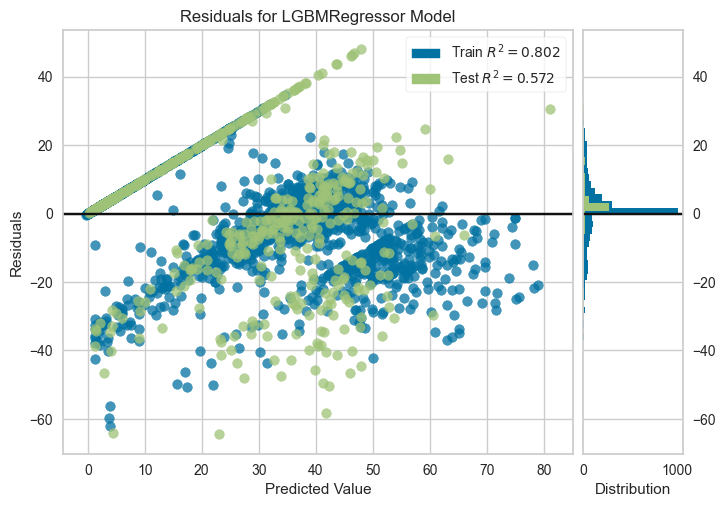

<Axes: title={'center': 'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [28]:
#residuals plot for svm
from yellowbrick.regressor import ResidualsPlot
# Initialize ResidualsPlot
visualizer = ResidualsPlot(forwards_lgbm_model_loaded)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and show the figure

c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


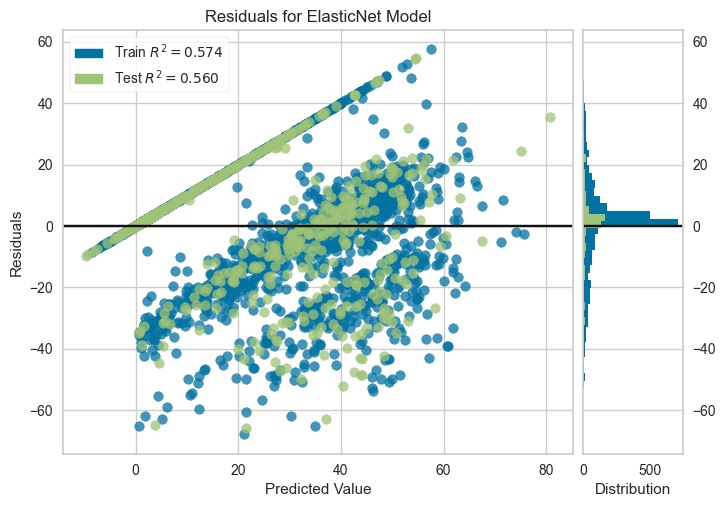

<Axes: title={'center': 'Residuals for ElasticNet Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [29]:
#residuals plot for svm
from yellowbrick.regressor import ResidualsPlot
# Initialize ResidualsPlot

visualizer = ResidualsPlot(forwards_elastic_model_loaded)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and show the figure